In [1]:
import warnings
import cufflinks
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import optimizers
from keras.layers import Dense
from keras.utils import to_categorical
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
warnings.filterwarnings("ignore")
cufflinks.go_offline(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

Using TensorFlow backend.


### Load data

In [2]:
train = pd.read_csv('../input/X_train.csv')
labels = pd.read_csv('../input/y_train.csv')
test = pd.read_csv('../input/X_test.csv')

### Join train features with labels

In [3]:
train = train.join(labels, on='series_id', rsuffix='_')
train.drop('series_id_', axis=1, inplace=True)
print(train.shape)
display(train.head())

(487680, 15)


,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532,13,fine_concrete
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128,13,fine_concrete
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267,13,fine_concrete
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960,13,fine_concrete
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410,13,fine_concrete


### Pre process the labels

In [4]:
target = train['surface']
n_labels = target.nunique()
labels_names = target.unique()
le = LabelEncoder()
target = le.fit_transform(target.values)
target = to_categorical(target)
train.drop('surface', axis=1, inplace=True)

### Train/validation split

In [5]:
features = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
            'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z', 
            'series_id', 'measurement_number']

X_train, X_val, Y_train, Y_val = train_test_split(train[features], target, test_size=0.2, random_state=0)

X_train.drop(['series_id', 'measurement_number'], axis=1, inplace=True)
X_val.drop(['series_id', 'measurement_number'], axis=1, inplace=True)
features = X_train.columns
print('Train shape', X_train.shape)
print('Validation shape', X_val.shape)
display(X_train.describe())

Train shape (390144, 6)
Validation shape (97536, 6)


,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000,390144.000000
mean,0.000074,0.008341,-0.019133,0.128868,2.887287,-9.363993
std,0.117635,0.088679,0.229197,1.868369,2.147481,2.840265
min,-2.014300,-0.927860,-1.268800,-31.142000,-121.490000,-75.386000
25%,-0.040834,-0.033167,-0.090595,-0.530402,1.959000,-10.192000
50%,0.000031,0.005396,-0.005198,0.124245,2.880700,-9.364300
75%,0.040461,0.048102,0.064889,0.791650,3.799325,-8.523200
max,2.282200,1.079100,1.272500,36.797000,73.008000,55.766000


### Model

In [6]:
epochs = 100
batch = 128
lr = 0.001
adam = optimizers.Adam(lr)

In [7]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_labels, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer=adam)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 585       
Total params: 9,737
Trainable params: 9,737
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train.values, Y_train, validation_data=(X_val.values, Y_val), epochs=epochs, verbose=2)

Train on 390144 samples, validate on 97536 samples
Epoch 1/100
 - 47s - loss: 1.7237 - val_loss: 1.6613
Epoch 2/100
 - 44s - loss: 1.6396 - val_loss: 1.6244
Epoch 3/100
 - 45s - loss: 1.6147 - val_loss: 1.6069
Epoch 4/100
 - 44s - loss: 1.6049 - val_loss: 1.6026
Epoch 5/100
 - 44s - loss: 1.5974 - val_loss: 1.6009
Epoch 6/100
 - 44s - loss: 1.5926 - val_loss: 1.5906
Epoch 7/100
 - 45s - loss: 1.5882 - val_loss: 1.5831
Epoch 8/100
 - 44s - loss: 1.5842 - val_loss: 1.5828
Epoch 9/100
 - 44s - loss: 1.5822 - val_loss: 1.5841
Epoch 10/100
 - 44s - loss: 1.5802 - val_loss: 1.5800
Epoch 11/100
 - 44s - loss: 1.5783 - val_loss: 1.5742
Epoch 12/100
 - 44s - loss: 1.5761 - val_loss: 1.5744
Epoch 13/100
 - 43s - loss: 1.5752 - val_loss: 1.5806
Epoch 14/100
 - 44s - loss: 1.5742 - val_loss: 1.5770
Epoch 15/100
 - 43s - loss: 1.5734 - val_loss: 1.5711
Epoch 16/100
 - 43s - loss: 1.5721 - val_loss: 1.5774
Epoch 17/100
 - 44s - loss: 1.5717 - val_loss: 1.5691
Epoch 18/100
 - 43s - loss: 1.5710 - val

#### Model loss plot

In [9]:
history_pd = pd.DataFrame.from_dict(history.history)
history_pd.iplot(kind='line')

#### Model evaluation

In [10]:
train_pred = model.predict_classes(X_train)
val_pred = model.predict_classes(X_val)
Y_train_max = np.argmax(Y_train, axis=1)
Y_val_max = np.argmax(Y_val, axis=1)

print('Train accuracy', accuracy_score(Y_train_max, train_pred))
print('Validation accuracy', accuracy_score(Y_val_max, val_pred))

Train accuracy 0.4210599163385827
Validation accuracy 0.4175278871391076


#### Model confusion matrix

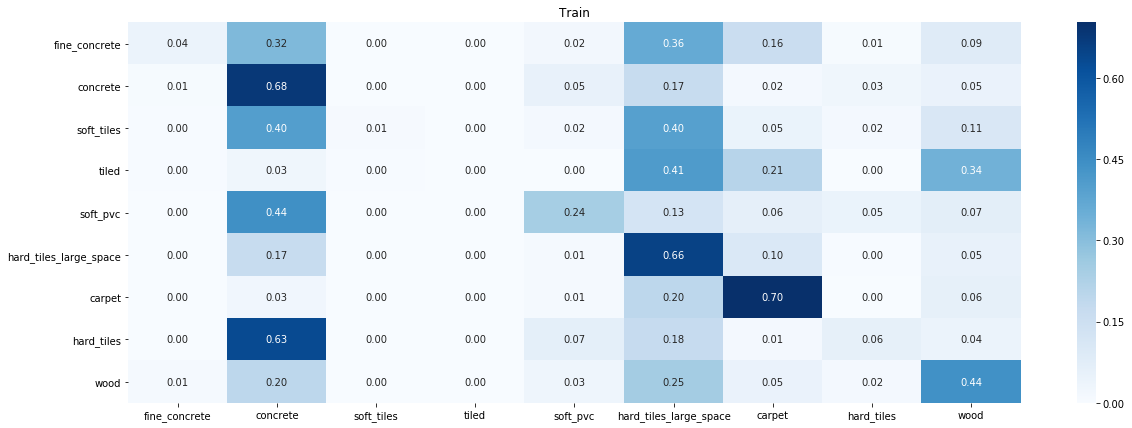

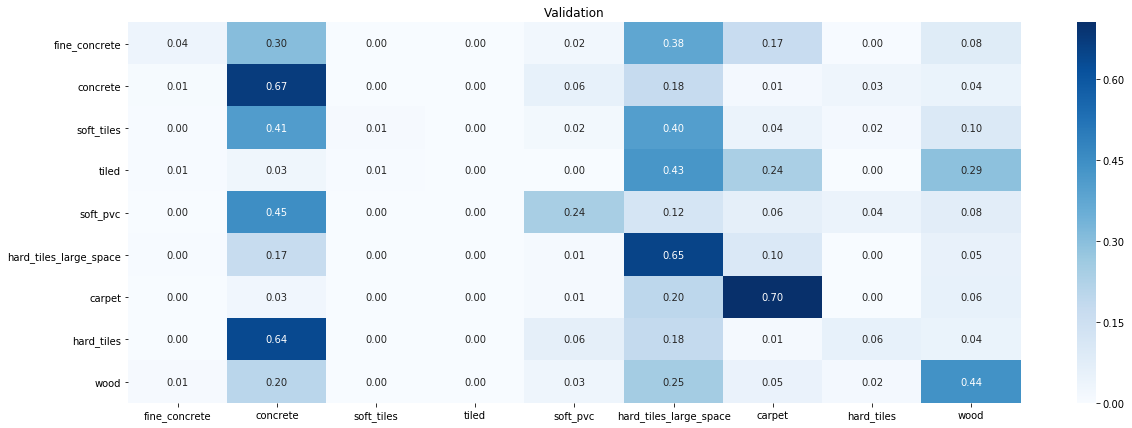

In [11]:
cnf_matrix = confusion_matrix(Y_train_max, train_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Train')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

cnf_matrix = confusion_matrix(Y_val_max, val_pred)
cnf_matrix_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cnf_matrix_norm, index=labels_names, columns=labels_names)

plt.figure(figsize=(20, 7))
ax = plt.axes()
ax.set_title('Validation')
sns.heatmap(df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax)
plt.show()

### Test predictions

In [ ]:
predictions = model.predict_classes(test[features].values)
test['surface'] = le.inverse_transform(predictions)
df = test[['series_id', 'surface']]
df = df.groupby('series_id', as_index=False).agg(lambda x:x.value_counts().index[0])
df.to_csv('submission.csv', index=False)
df.head(10)